## ASSIGNMENT-2
Names and Roll Numbers:
- Sarthak Mishra: 2023701027 
- Samaksh Ujjawal: 2024702013
- Rohit Pawar: 2024701025
- Soham Patil: 2024701005

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3
import torch
import torch.optim as optim
from scipy.spatial.transform import Rotation

device = torch.device('cpu')

def getTransform():
    R = Rotation.from_euler('xyz', np.random.uniform(0, 2 * np.pi, 3)).as_matrix()
    T = np.random.uniform(-250, 250, 3)
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T
    return transformation_matrix

def matrix_to_se3(transformation_matrix):
    rotation_matrices = transformation_matrix[:3, :3]
    translations = transformation_matrix[:3, 3]
    quaternions = Rotation.from_matrix(rotation_matrices).as_quat()
    pose_data = np.concatenate((translations, quaternions), axis=-1)
    pose_tensor = torch.tensor(pose_data, dtype=torch.float32)
    se3_obj = SE3.InitFromVec(pose_tensor)
    return se3_obj

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    transformation_matrix = SE3_transform.matrix()
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    return transformed_points

def compute_loss(frame0_pcl, frame1_pcl, transform01):
    residual = frame0_pcl - transform_point_cloud(frame1_pcl,transform01)
    loss = torch.norm(residual, dim=1).pow(2).mean()
    return loss

def icp_with_svd(pcl0, pcl1):
    centroid_pcl0 = np.mean(pcl0, axis=0)
    centroid_pcl1 = np.mean(pcl1, axis=0)
    centered_pcl0 = pcl0 - centroid_pcl0
    centered_pcl1 = pcl1 - centroid_pcl1
    H = centered_pcl0.T @ centered_pcl1
    U, D, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        R[:, 2] *= -1
    t = centroid_pcl0 - R @ centroid_pcl1
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


6.0064005851745605
5.9727959632873535
5.949156284332275
5.929537773132324
5.908344268798828
5.888301372528076
5.86834716796875
5.848139762878418
5.827783584594727
5.805417060852051
5.7824273109436035
5.758920192718506
5.734910488128662
5.709904193878174
5.682576656341553
5.654819488525391
5.625478267669678
5.595974922180176
5.565799713134766
5.5356221199035645
5.5052995681762695
5.474112510681152
5.442054271697998
5.4101786613464355
5.377349376678467
5.345536231994629
5.314770221710205
5.282797813415527
5.251790523529053
5.2213358879089355
5.191075325012207
5.161251544952393
5.131003379821777
5.100350379943848
5.069804668426514
5.039384841918945
5.007827281951904
4.975592136383057
Converged in 37 iterations with 4.9756 error.


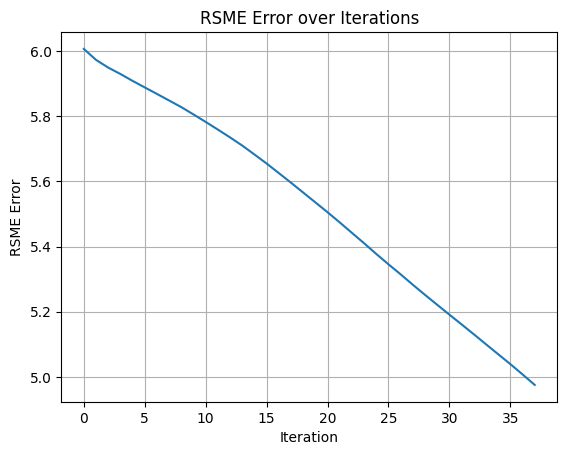

In [2]:
BIGN = 2
class yee(object):
    def __init__(self,id,open_visual,home_pcl,downsample):
        self.home_pcl_tensor = torch.tensor(np.array(home_pcl.points), dtype=torch.float32)
        self.open_visual = open_visual
        self.frame_num = id
        self.point_transform = matrix_to_se3(getTransform())
        self.pcl = transform_point_cloud(self.home_pcl_tensor + torch.randn_like(self.home_pcl_tensor) * 1, self.point_transform, downsample)
        self.pcl_tensor = self.pcl.requires_grad_(True)
        self.pcl_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(self.pcl.detach().numpy()))
        self.pcl_geom.paint_uniform_color([0.0,0.0,1.0])
        self.frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
        self.frame_tensor = torch.tensor(np.array(self.frame.vertices), dtype=torch.float32)
        self.frame_transform = matrix_to_se3(np.eye(4))
        self.open_visual.add_geometry(self.pcl_geom)
        self.open_visual.add_geometry(self.frame)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()
        
    def update_geom(self):
        self.pcl_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(self.pcl_tensor,self.frame_transform).detach().cpu().numpy())
        self.frame.vertices = o3d.utility.Vector3dVector(transform_point_cloud(self.frame_tensor,self.frame_transform).detach().cpu().numpy())
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.update_geometry(self.frame)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()
        
    def remove_pcl(self):
        self.pcl_geom.points = o3d.utility.Vector3dVector(np.empty((0,3)))
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()

    def update_color(self,color):
        self.pcl_geom.paint_uniform_color(color)
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()

pcl = o3d.io.read_point_cloud('data/toothless.ply')

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.get_render_option().point_size = 1.5

frames = []
for frame_num in range(BIGN):
    frames.append(yee(frame_num,vis,pcl,0.2))
frames[0].update_color([1.0,0.0,0.0])

for frame in frames:
    frame.frame_transform = matrix_to_se3(icp_with_svd(frames[0].pcl.detach().numpy(),frame.pcl.detach().numpy()))
    frame.update_geom()

class Model(torch.nn.Module):
    def __init__(self, num, home_pcl_tensor):
        super(Model, self).__init__()
        self.num = num
        epsilon_list = []
        for frame_num in range(1, len(frames)):
            se3_log = SE3.log(frames[frame_num].frame_transform).view(-1)
            epsilon_list.append(se3_log)

        self.epsilon = torch.nn.Parameter(torch.cat(epsilon_list, dim=0))
        self.points = torch.nn.Parameter(home_pcl_tensor.clone())

    def forward(self):
        epsilon_reshaped = self.epsilon.view(self.num, 6)
        self.se3transforms = SE3.exp(epsilon_reshaped)
        return self.se3transforms, self.points
    
model = Model(BIGN-1,frames[0].pcl_tensor)
optimizer = optim.Adam([
    {'params': model.epsilon, 'lr': 9e-5},
    {'params': model.points, 'lr': 5e-3},
])
errors = []

for iteration in range(400):
    optimizer.zero_grad()
    se3transforms,home_pcl_opti = model.forward()
    frames[0].pcl_tensor = home_pcl_opti
    temp_loss = 0
    for frame_num in range(1,BIGN):
        frames[frame_num].frame_transform = se3transforms[frame_num-1]
        temp_loss += compute_loss(home_pcl_opti,frames[frame_num].pcl_tensor,frames[frame_num].frame_transform)
    loss = temp_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    for frame in frames:
        frame.update_geom()
    error = loss.item()/(BIGN-1)
    print(error)
    errors.append(error)

    if error < 5e0:
        frames[0].update_color([0.0,1.0,0.0])
        for frame_iteration in range(1,BIGN):
            frames[frame_iteration].remove_pcl()
        print(f"Converged in {iteration} iterations with {error:.4f} error.")
        break

if error > 5e0:
    print("Failed to converge")

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

<table>
    <tr>
        <td><h3>Task Part 2 Q1</h3><img src="./part 2 q1.gif" width="700"/></td>
    </tr>
</table>

### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from lietorch import SE3
import torch
import torch.optim as optim
from scipy.spatial.transform import Rotation

device = torch.device('cpu')

def getTransforms():
    # N = 2 + int(torch.rand(1) * 3)
    N = 5
    euler_angles = torch.rand(N, 3) * 2 * torch.pi 
    translation = torch.rand(N, 3) * 500
    transformation_params = torch.cat((translation, euler_angles), dim=1)
    return SE3.exp(transformation_params).matrix()

def matrix_to_se3(transformation_matrix):
    rotation_matrices = transformation_matrix[:3, :3]
    translations = transformation_matrix[:3, 3]
    quaternions = Rotation.from_matrix(rotation_matrices).as_quat()
    pose_data = np.concatenate((translations, quaternions), axis=-1)
    pose_tensor = torch.tensor(pose_data, dtype=torch.float32)
    se3_obj = SE3.InitFromVec(pose_tensor)
    return se3_obj

def transform_point_cloud(point_cloud, SE3_transform, downsample=1.0):
    if downsample < 1.0:
        indices = torch.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]
    transformation_matrix = SE3_transform.matrix()
    rotated_points = torch.matmul(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]
    return transformed_points

def compute_loss(frame0_pcl, frame1_pcl, transform01):
    residual = frame0_pcl - transform_point_cloud(frame1_pcl,transform01)
    loss = torch.norm(residual, dim=1).pow(2).mean()
    return loss

def icp_with_svd(pcl0, pcl1):
    centroid_pcl0 = np.mean(pcl0, axis=0)
    centroid_pcl1 = np.mean(pcl1, axis=0)
    centered_pcl0 = pcl0 - centroid_pcl0
    centered_pcl1 = pcl1 - centroid_pcl1
    H = centered_pcl0.T @ centered_pcl1
    U, D, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        R[:, 2] *= -1
    t = centroid_pcl0 - R @ centroid_pcl1
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


6.000304222106934
36.70161819458008
29.740474700927734
13.94343376159668
9.711371421813965
9.910334587097168
11.278945922851562
12.396509170532227
12.77519702911377
11.145222663879395
8.95550537109375
9.613577842712402
12.15977954864502
12.79534912109375
11.344690322875977
10.321192741394043
11.978899002075195
13.444489479064941
13.193912506103516
12.031157493591309
11.934213638305664
12.832099914550781
12.845634460449219
12.297998428344727
12.539644241333008
12.916498184204102
12.720602035522461
12.440337181091309
12.484484672546387
12.568541526794434
12.406625747680664
12.118703842163086
12.187799453735352
12.105497360229492
11.714717864990234
11.819159507751465
11.742457389831543
11.338804244995117
11.20352554321289
11.101228713989258
10.864561080932617
10.501197814941406
10.41661548614502
10.107304573059082
10.040291786193848
9.87071704864502
9.469797134399414
9.599064826965332
9.48677921295166
8.930309295654297
8.848773002624512
8.78053092956543
8.463013648986816
8.19013500213623


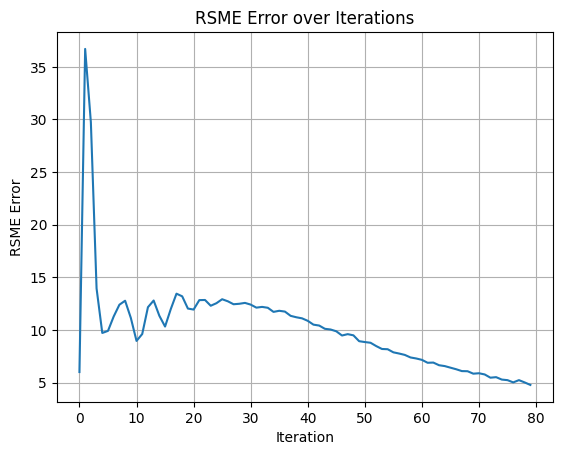

In [2]:
transforms = getTransforms()
BIGN = transforms.shape[0]


class yee(object):
    def __init__(self,id,open_visual,home_pcl,downsample):
        self.home_pcl_tensor = torch.tensor(np.array(home_pcl.points), dtype=torch.float32)
        self.open_visual = open_visual
        self.frame_num = id
        self.point_transform = matrix_to_se3(transforms[id])
        self.pcl = transform_point_cloud(self.home_pcl_tensor + torch.randn_like(self.home_pcl_tensor) * 1, self.point_transform, downsample)
        self.pcl_tensor = self.pcl.requires_grad_(True)
        self.pcl_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(self.pcl.detach().numpy()))
        self.pcl_geom.paint_uniform_color([0.0,0.0,1.0])
        self.frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
        self.frame_tensor = torch.tensor(np.array(self.frame.vertices), dtype=torch.float32)
        self.frame_transform = matrix_to_se3(np.eye(4))
        self.open_visual.add_geometry(self.pcl_geom)
        self.open_visual.add_geometry(self.frame)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()
        
    def update_geom(self):
        self.pcl_geom.points = o3d.utility.Vector3dVector(transform_point_cloud(self.pcl_tensor,self.frame_transform).detach().cpu().numpy())
        self.frame.vertices = o3d.utility.Vector3dVector(transform_point_cloud(self.frame_tensor,self.frame_transform).detach().cpu().numpy())
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.update_geometry(self.frame)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()
        
    def remove_pcl(self):
        self.pcl_geom.points = o3d.utility.Vector3dVector(np.empty((0,3)))
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()

    def update_color(self,color):
        self.pcl_geom.paint_uniform_color(color)
        self.open_visual.update_geometry(self.pcl_geom)
        self.open_visual.poll_events()
        self.open_visual.update_renderer()

pcl = o3d.io.read_point_cloud('data/toothless.ply')

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.get_render_option().point_size = 1.5

frames = []
for frame_num in range(BIGN):
    frames.append(yee(frame_num,vis,pcl,0.2))
frames[0].update_color([1.0,0.0,0.0])

for frame in frames:
    frame.frame_transform = matrix_to_se3(icp_with_svd(frames[0].pcl.detach().numpy(),frame.pcl.detach().numpy()))
    frame.update_geom()

class Model(torch.nn.Module):
    def __init__(self, num, home_pcl_tensor):
        super(Model, self).__init__()
        self.num = num
        epsilon_list = []
        for frame_num in range(1, len(frames)):
            se3_log = SE3.log(frames[frame_num].frame_transform).view(-1)
            epsilon_list.append(se3_log)

        self.epsilon = torch.nn.Parameter(torch.cat(epsilon_list, dim=0))
        self.points = torch.nn.Parameter(home_pcl_tensor.clone())

    def forward(self):
        epsilon_reshaped = self.epsilon.view(self.num, 6)
        self.se3transforms = SE3.exp(epsilon_reshaped)
        return self.se3transforms, self.points
    
model = Model(BIGN-1,frames[0].pcl_tensor)
optimizer = optim.Adam([
    {'params': model.epsilon, 'lr': 9e-3},
    {'params': model.points, 'lr': 5e-1},
])
errors = []

for iteration in range(400):
    optimizer.zero_grad()
    se3transforms,home_pcl_opti = model.forward()
    frames[0].pcl_tensor = home_pcl_opti
    temp_loss = 0
    for frame_num in range(1,BIGN):
        frames[frame_num].frame_transform = se3transforms[frame_num-1]
        temp_loss += compute_loss(home_pcl_opti,frames[frame_num].pcl_tensor,frames[frame_num].frame_transform)
    loss = temp_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()

    for frame in frames:
        frame.update_geom()
    error = loss.item()/(BIGN-1)
    print(error)
    errors.append(error)

    if error < 5e0:
        frames[0].update_color([0.0,1.0,0.0])
        for frame_iteration in range(1,BIGN):
            frames[frame_iteration].remove_pcl()
        print(f"Converged in {iteration} iterations with {error:.4f} error.")
        break

if error > 5e0:
    print("Failed to converge")

vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()

<table>
    <tr>
        <td><h3>Task Part 2 Q2</h3><img src="./part 2 q2.gif" width="700"/></td>
    </tr>
</table>